# Zillow Exploration
After successfully splitting the data using our functions we will explore the data to determine best features to use in our modeling. Per our guidance, the MVP will use square feet of the home, number of bedrooms, and number of bathrooms to attempt to predict the price (measured as taxvaluedollarcnt) of the home. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import wrangle
import prepare
import acquire
print('Success')

Success


# Testing Functions
The below lines of code is used to ensure that the acquire and prepare files are working correctly and to put the zillow data into Dataframes for processing. We will then split the DFs into train, validate, test data sets. 

In [2]:
zillow = acquire.load_zillow_data()
zillow.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
1,1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,...,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.37,NaN,NaN,NaN
3,3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,...,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.57,NaN,NaN,NaN
4,4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,...,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.17,NaN,NaN,NaN


In [3]:
df = prepare.prepare_zillow()
df.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fips', 'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'propertylandusetypeid',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock'],
      dtype='object')

In [4]:
dfmvp = prepare.prepare_zillow_mvp()
dfmvp.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,more_than_two_bath
20,2.0,4.0,3633.0,296425.0,0
31,4.0,3.0,1620.0,847770.0,1
33,2.0,3.0,2077.0,646760.0,0
110,1.0,3.0,1244.0,169471.0,0
111,2.0,3.0,1300.0,233266.0,0


In [5]:
help(wrangle)

Help on module wrangle:

NAME
    wrangle

FUNCTIONS
    add_encoded_columns(df, drop_encoders=True)
        Signature: add_encoded_columns(df, drop_encoders=True)
        Docstring:
        This function accepts a DataFrame, creates encoded columns for object dtypes,
        and returns a DataFrame with or without object dtype columns.
        
        Parameters
        ----------
        df : pandas.core.frame.DataFrame
        
        
        Returns
        -------
        f, encoded_columns
    
    add_scaled_columns(X_train, X_validate, X_test, scaler=MinMaxScaler())
        Signature: add_scaled_columns(train, validate, test, scaler)
        Docstring:
        
        Parameters
        ----------
        pandas.core.frame.DataFrame
        
        
        Returns
        -------
        X_train, X_validate, X_test
    
    attributes_target_split(data_set, target_name)
        Signature: attributes_target_split(df, target)
        Docstring:
        
        Parameters
 

In [6]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.wrangle_data(dfmvp, 'taxvaluedollarcnt', modeling=True)


In [7]:
train = pd.concat([X_train, y_train], axis = 1)
train.corr()

,bathroomcnt_scaled,bedroomcnt_scaled,calculatedfinishedsquarefeet_scaled,more_than_two_bath_scaled,taxvaluedollarcnt
bathroomcnt_scaled,1.000000,0.640005,0.644051,0.762912,0.508227
bedroomcnt_scaled,0.640005,1.000000,0.466375,0.506296,0.258013
calculatedfinishedsquarefeet_scaled,0.644051,0.466375,1.000000,0.490542,0.468594
more_than_two_bath_scaled,0.762912,0.506296,0.490542,1.000000,0.308074
taxvaluedollarcnt,0.508227,0.258013,0.468594,0.308074,1.000000


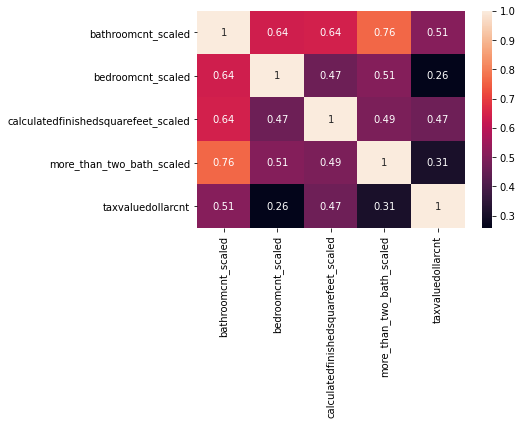

In [8]:
sns.heatmap(train.corr(), annot=True)

We'll do a correlation test on the highest correlations (bedroom count and calculated square footage)

* $H0$ - There is no relationship between taxvaluedollarcnt and bathroomcnt"
* $Ha$ - There is a relationship between taxvaluedollarcnt and bathroomcnt

In [9]:
from math import sqrt
from scipy import stats
a = .05
corr, p = stats.pearsonr(train['calculatedfinishedsquarefeet_scaled'], train['taxvaluedollarcnt'])
print(corr, p)
if p > a:
    print('We Fail to Reject H0')
else:
    print('We Reject H0a')

0.4685943340719585 0.0
We Reject H0a


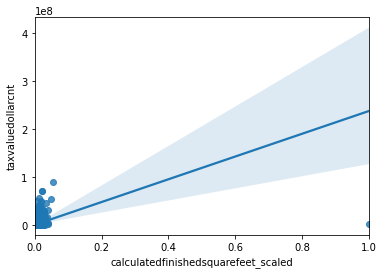

In [10]:
sns.regplot(data=train, x='calculatedfinishedsquarefeet_scaled', y = 'taxvaluedollarcnt')

In [11]:
corr, p = stats.pearsonr(train['bedroomcnt_scaled'], train['taxvaluedollarcnt'])
print(corr, p)
if p > a:
    print('We Fail to Reject H0')
else:
    print('We Reject H0')

0.2580125849705239 0.0
We Reject H0


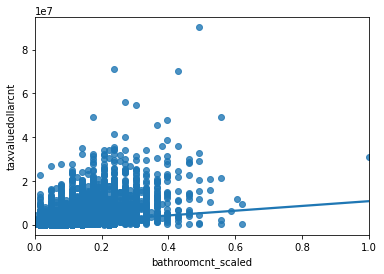

In [12]:
sns.regplot(data=train, x='bathroomcnt_scaled', y = 'taxvaluedollarcnt')

# MVP v2
## Outlier Detection
To properly create a model we will need to determine if there are any outliers in the data and then address them. We will do that below using 

In [13]:
des = zillow[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'roomcnt', 'yearbuilt', 'landtaxvaluedollarcnt']].describe()
des

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,roomcnt,yearbuilt,landtaxvaluedollarcnt
count,2.982260e+06,2.982272e+06,2.940120e+06,2.982248e+06,2.937384e+06,2.925291e+06
mean,2.216196e+00,3.093362e+00,1.831455e+03,1.474357e+00,1.964438e+03,2.684558e+05
std,1.078250e+00,1.271569e+00,1.954198e+03,2.839869e+00,2.364428e+01,4.865097e+05
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.801000e+03,1.000000e+00
25%,2.000000e+00,2.000000e+00,1.215000e+03,0.000000e+00,1.950000e+03,7.970000e+04
50%,2.000000e+00,3.000000e+00,1.574000e+03,0.000000e+00,1.963000e+03,1.766190e+05
75%,3.000000e+00,4.000000e+00,2.140000e+03,0.000000e+00,1.981000e+03,3.261000e+05
max,3.200000e+01,2.500000e+01,9.525760e+05,9.600000e+01,2.016000e+03,9.401108e+07


In [14]:
columns = list(des.columns)

outliers = []
for col in columns:
    IQR = (des[col].iloc[6] - des[col].iloc[4])
    Q3 = des[col].iloc[6]
    Q1 = des[col].iloc[4]
    little_outliers = Q1 - (1.5 * IQR)
    big_outliers = Q3 + (1.5 * IQR)
    outliers.append([IQR, Q3, Q1, little_outliers, big_outliers])

outliers = np.array(outliers)
df_outliers = pd.DataFrame(data=outliers, index = columns, columns = ['IQR', 'Q3', 'Q1', 'little_outliers', 'big_outliers'])
df_outliers

big_outliers = df_outliers[['big_outliers']].transpose()
big_outliers

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,roomcnt,yearbuilt,landtaxvaluedollarcnt
big_outliers,4.5,7.0,3527.5,0.0,2027.5,695700.0


In [15]:
little_outliers = df_outliers[['little_outliers']].transpose()
little_outliers

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,roomcnt,yearbuilt,landtaxvaluedollarcnt
little_outliers,0.5,-1.0,-172.5,0.0,1903.5,-289900.0


In [16]:
df['bathroomcnt_outlier'] = (df['bathroomcnt'] > 4.5) | (df['bathroomcnt'] < .05)
df['bedroomcnt_outlier'] = (df['bedroomcnt'] > 5.5) | (df['bedroomcnt'] < 1.5)
df['calculatedfinishedsquarefeet_outlier'] = (df['calculatedfinishedsquarefeet'] > 3633.0)
df['roomcnt_outlier'] = (df['roomcnt'] > 12.5)
df['yearbuilt_outlier'] = (df['yearbuilt'] > 2016.5) | (df['yearbuilt'] < 1908.5)
df['landtaxvaluedollarcnt_outlier'] = (df['landtaxvaluedollarcnt'] > 743335.5) 


In [17]:
print(f"bathroomcnt_outlier - {df['bathroomcnt_outlier'].sum()/df.shape[0] * 100}")
print(f"bedroomcnt_outlier - {df['bedroomcnt_outlier'].sum()/df.shape[0] * 100}")
print(f"calculatedfinishedsquarefeet_outlier - {df['calculatedfinishedsquarefeet_outlier'].sum()/df.shape[0] * 100}")
print(f"roomcnt_outlier - {df['roomcnt_outlier'].sum()/df.shape[0] * 100}")
print(f"yearbuilt_outlier - {df['yearbuilt_outlier'].sum()/df.shape[0] * 100}")
print(f"landtaxvaluedollarcnt_outlier - {df['landtaxvaluedollarcnt_outlier'].sum()/df.shape[0] * 100}")

bathroomcnt_outlier - 2.5553958851775262
bedroomcnt_outlier - 2.601661350811398
calculatedfinishedsquarefeet_outlier - 4.492049583493977
roomcnt_outlier - 0.028787400838853644
yearbuilt_outlier - 0.838806911780169
landtaxvaluedollarcnt_outlier - 5.558258268783662


In [18]:
df.shape

(2139825, 29)

In [19]:
df.drop(df.loc[df['bathroomcnt_outlier']==True].index, inplace=True)
df.drop(df.loc[df['bedroomcnt_outlier']==True].index, inplace=True)
df.drop(df.loc[df['calculatedfinishedsquarefeet_outlier']==True].index, inplace=True)
df.drop(df.loc[df['roomcnt_outlier']==True].index, inplace=True)
df.drop(df.loc[df['yearbuilt_outlier']==True].index, inplace=True)
df.shape


(1978229, 29)

In [20]:
print(f"Percentage of rows removed is {(1 - 1978229/2139825) * 100}")

Percentage of rows removed is 7.551832509667844


In [ ]:
# Drop the outlier columns we created
df.drop(columns=['bathroomcnt_outlier', 'bedroomcnt_outlier', 'calculatedfinishedsquarefeet_outlier',
                 'roomcnt_outlier', 'yearbuilt_outlier', 'landtaxvaluedollarcnt_outlier'], inplace=True)

In [23]:
# Drop all the nan rows that are present (less than 1% of the total data)
df.dropna(inplace=True)

In [24]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.wrangle_data(df, 'taxvaluedollarcnt', modeling=False)
X_train.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,...,propertycountylandusecode_0134,propertycountylandusecode_0140,propertycountylandusecode_0141,propertycountylandusecode_01MC,propertycountylandusecode_1,propertycountylandusecode_101,propertycountylandusecode_1110,propertycountylandusecode_1111,propertycountylandusecode_1112,propertycountylandusecode_122
1613195,11009598,3.0,3.0,2669.0,6037.0,3.0,34301040.0,-118525690.0,20389.0,261.0,...,0,0,0,0,0,0,0,0,0,0
2651063,14180632,2.5,4.0,2004.0,6059.0,2.0,33869075.0,-117858369.0,2720.0,261.0,...,0,0,0,0,0,0,0,0,0,1
1429164,14312934,2.0,2.0,2079.0,6059.0,2.0,33607827.0,-117861452.0,6205.0,261.0,...,0,0,0,0,0,0,0,0,0,1
865690,17159702,2.0,2.0,1220.0,6111.0,2.0,34210997.0,-119184629.0,6978.0,261.0,...,0,0,0,0,0,0,1,0,0,0
1547909,14147050,3.0,4.0,2115.0,6059.0,3.0,33904191.0,-117912969.0,10625.0,261.0,...,0,0,0,0,0,0,0,0,0,1


In [29]:
df.shape

(1929494, 24)

In [25]:
X_train.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fips', 'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock', 'landtaxvaluedollarcnt_outlier',
       'propertycountylandusecode_0100', 'propertycountylandusecode_0101',
       'propertycountylandusecode_0102', 'propertycountylandusecode_0103',
       'propertycountylandusecode_0104', 'propertycountylandusecode_0105',
       'propertycountylandusecode_0106', 'propertycountylandusecode_0108',
       'propertycountylandusecode_0109', 'propertycountylandusecode_010G',
       'propertycountylandusecode_010L', 'propertycountylandusecode_010M',
       'propertycountylandusecode_010X', 'propertycountylandusecode_010Y',
       'propertycountylan

In [27]:
# Drop columns we can't use for K best due to values

k_X_train = X_train.drop(columns=['parcelid', 'fips', 'latitude', 'longitude', 'propertylandusetypeid', 'rawcensustractandblock',
                     'regionidcity', 'regionidcounty', 'regionidzip', 'censustractandblock', 'landtaxvaluedollarcnt_outlier',
                     'structuretaxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
                     'taxamount', 'censustractandblock'])
k_X_validate = X_validate.drop(columns=['parcelid', 'fips', 'latitude', 'longitude', 'propertylandusetypeid', 'rawcensustractandblock',
                     'regionidcity', 'regionidcounty', 'regionidzip', 'censustractandblock', 'landtaxvaluedollarcnt_outlier',
                     'structuretaxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
                     'taxamount', 'censustractandblock'])
k_X_test = X_test.drop(columns=['parcelid', 'fips', 'latitude', 'longitude', 'propertylandusetypeid', 'rawcensustractandblock',
                     'regionidcity', 'regionidcounty', 'regionidzip', 'censustractandblock','landtaxvaluedollarcnt_outlier', 
                     'structuretaxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
                     'taxamount', 'censustractandblock'])

In [28]:
k_X_train.shape

(1234876, 39)

In [30]:
from sklearn.feature_selection import SelectKBest, f_regression

# Create the f_selector object 
f_selector = SelectKBest(f_regression, k=10)

# fit the selector to the training data
f_selector.fit(k_X_train, y_train)

# Reduce the training data by transforming the X_train data set to the f_selector
X_reduced = f_selector.transform(k_X_train)

# Use get support to create a mask
f_support = f_selector.get_support()

f_feature = k_X_train.loc[:,f_support].columns.tolist()

print(str(len(f_feature)), 'selected features')
print(f_feature)

C:\Users\anthony\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\anthony\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


10 selected features
['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'yearbuilt', 'propertycountylandusecode_0100', 'propertycountylandusecode_0101', 'propertycountylandusecode_0103', 'propertycountylandusecode_1', 'propertycountylandusecode_122']


In [31]:
wrangle.select_kbest(k_X_train, y_train, k_features=10)

Select K Best: 10 features
['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'yearbuilt', 'propertycountylandusecode_0100', 'propertycountylandusecode_0101', 'propertycountylandusecode_0103', 'propertycountylandusecode_1', 'propertycountylandusecode_122']


C:\Users\anthony\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\anthony\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,propertycountylandusecode_0100,propertycountylandusecode_0101,propertycountylandusecode_0103,propertycountylandusecode_1,propertycountylandusecode_122
1613195,3.0,3.0,2669.0,3.0,1988.0,0,1,0,0,0
2651063,2.5,4.0,2004.0,2.0,1976.0,0,0,0,0,1
1429164,2.0,2.0,2079.0,2.0,1976.0,0,0,0,0,1
865690,2.0,2.0,1220.0,2.0,1950.0,0,0,0,0,0
1547909,3.0,4.0,2115.0,3.0,1963.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2646050,1.0,2.0,900.0,1.0,1961.0,1,0,0,0,0
957678,2.0,4.0,1694.0,2.0,1990.0,1,0,0,0,0
2126622,1.0,3.0,1139.0,1.0,1954.0,1,0,0,0,0
946345,1.0,3.0,1184.0,1.0,1946.0,1,0,0,0,0
